In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import cv2
import numpy as np
import copy


class image_dehazer():
    def __init__(self, airlightEstimation_windowSze=15, boundaryConstraint_windowSze=3, C0=20, C1=300,
                 regularize_lambda=0.1, sigma=0.5, delta=0.85, showHazeTransmissionMap=True):
        self.airlightEstimation_windowSze = airlightEstimation_windowSze
        self.boundaryConstraint_windowSze = boundaryConstraint_windowSze
        self.C0 = C0
        self.C1 = C1
        self.regularize_lambda = regularize_lambda
        self.sigma = sigma
        self.delta = delta
        self.showHazeTransmissionMap = showHazeTransmissionMap
        self._A = []
        self._transmission = []
        self._WFun = []

    # Airlight estimation method: Estimates the atmospheric light in the image
    def __AirlightEstimation(self, HazeImg):
        # Check if the image is a color image (3 channels) or grayscale (1 channel)
        if len(HazeImg.shape) == 3:
            # Loop through each color channel
            for ch in range(len(HazeImg.shape)):
                # Create a morphological kernel for opening operation
                kernel = np.ones((self.airlightEstimation_windowSze, self.airlightEstimation_windowSze), np.uint8)
                # Apply morphological opening to the current color channel
                minImg = cv2.morphologyEx(HazeImg[:, :, ch], cv2.MORPH_OPEN, kernel)
                # Append the maximum pixel value after opening to the airlight estimation list
                self._A.append(int(minImg.max()))
        else:
            # For grayscale images, perform morphological opening and append the maximum pixel value
            kernel = np.ones((self.airlightEstimation_windowSze, self.airlightEstimation_windowSze), np.uint8)
            minImg = cv2.morphologyEx(HazeImg, cv2.MORPH_OPEN, kernel)
            self._A.append(int(minImg.max()))

    # Boundary constraint method: Computes the haze transmission map with boundary constraints
    def __BoundCon(self, HazeImg):
        if len(HazeImg.shape) == 3:
            # Calculate transmission for each color channel independently
            t_b = np.maximum((self._A[0] - HazeImg[:, :, 0].astype(float)) / (self._A[0] - self.C0),
                             (HazeImg[:, :, 0].astype(float) - self._A[0]) / (self.C1 - self._A[0]))
            t_g = np.maximum((self._A[1] - HazeImg[:, :, 1].astype(float)) / (self._A[1] - self.C0),
                             (HazeImg[:, :, 1].astype(float) - self._A[1]) / (self.C1 - self._A[1]))
            t_r = np.maximum((self._A[2] - HazeImg[:, :, 2].astype(float)) / (self._A[2] - self.C0),
                             (HazeImg[:, :, 2].astype(float) - self._A[2]) / (self.C1 - self._A[2]))

            # Find the maximum transmission value among color channels
            MaxVal = np.maximum(t_b, t_g, t_r)
            # Set the final transmission map as the minimum between the maximum and 1
            self._Transmission = np.minimum(MaxVal, 1)
        else:
            # For grayscale images, compute transmission with boundary constraints
            self._Transmission = np.maximum((self._A[0] - HazeImg.astype(float)) / (self._A[0] - self.C0),
                                            (HazeImg.astype(float) - self._A[0]) / (self.C1 - self._A[0]))
            # Ensure transmission values are between 0 and 1
            self._Transmission = np.minimum(self._Transmission, 1)

            # Apply morphological closing to the transmission map to enforce boundary constraints
        kernel = np.ones((self.boundaryConstraint_windowSze, self.boundaryConstraint_windowSze), float)
        self._Transmission = cv2.morphologyEx(self._Transmission, cv2.MORPH_CLOSE, kernel=kernel)

    def __LoadFilterBank(self):
        kirsch_filters = []
        kirsch_filters.append(np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]))
        kirsch_filters.append(np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]))
        kirsch_filters.append(np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]))
        kirsch_filters.append(np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]))
        kirsch_filters.append(np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]))
        kirsch_filters.append(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]))
        kirsch_filters.append(np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]))
        kirsch_filters.append(np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]))
        kirsch_filters.append(np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]))
        kirsch_filters.append(np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]))
        kirsch_filters.append(np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]))
        kirsch_filters.append(np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]))
        kirsch_filters.append(np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]))
        kirsch_filters.append(np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]))
        kirsch_filters.append(np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]))
        kirsch_filters.append(np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]))
        kirsch_filters.append(np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]))

        return kirsch_filters

    def __CalculateWeightingFunction(self, HazeImg, Filter):

        # Computing the weight function... Eq (17) in the paper

        HazeImageDouble = HazeImg.astype(float) / 255.0
        if (len(HazeImg.shape) == 3):
            Red = HazeImageDouble[:, :, 2]
            d_r = self.__circularConvFilt(Red, Filter)

            Green = HazeImageDouble[:, :, 1]
            d_g = self.__circularConvFilt(Green, Filter)

            Blue = HazeImageDouble[:, :, 0]
            d_b = self.__circularConvFilt(Blue, Filter)

            return (np.exp(-((d_r ** 2) + (d_g ** 2) + (d_b ** 2)) / (2 * self.sigma * self.sigma)))
        else:
            d = self.__circularConvFilt(HazeImageDouble, Filter)
            return (np.exp(-((d ** 2) + (d ** 2) + (d ** 2)) / (2 * self.sigma * self.sigma)))

    def __circularConvFilt(self, Img, Filter):
        FilterHeight, FilterWidth = Filter.shape
        assert (FilterHeight == FilterWidth), 'Filter must be square in shape --> Height must be same as width'
        assert (FilterHeight % 2 == 1), 'Filter dimension must be a odd number.'

        filterHalsSize = int((FilterHeight - 1) / 2)
        rows, cols = Img.shape
        PaddedImg = cv2.copyMakeBorder(Img, filterHalsSize, filterHalsSize, filterHalsSize, filterHalsSize,
                                       borderType=cv2.BORDER_WRAP)
        FilteredImg = cv2.filter2D(PaddedImg, -1, Filter)
        Result = FilteredImg[filterHalsSize:rows + filterHalsSize, filterHalsSize:cols + filterHalsSize]
        return (Result)

    def __CalTransmission(self, HazeImg):
        rows, cols = self._Transmission.shape

        KirschFilters = self.__LoadFilterBank()

        # Normalize the filters
        for idx, currentFilter in enumerate(KirschFilters):
            KirschFilters[idx] = KirschFilters[idx] / np.linalg.norm(currentFilter)

        # Calculate Weighting function --> [rows, cols. numFilters] --> One Weighting function for every filter
        WFun = []
        for idx, currentFilter in enumerate(KirschFilters):
            WFun.append(self.__CalculateWeightingFunction(HazeImg, currentFilter))

        # Precompute the constants that are later needed in the optimization step
        tF = np.fft.fft2(self._Transmission)
        DS = 0

        for i in range(len(KirschFilters)):
            D = self.__psf2otf(KirschFilters[i], (rows, cols))
            # D = psf2otf(KirschFilters[i], (rows, cols))
            DS = DS + (abs(D) ** 2)

        # Cyclic loop for refining t and u --> Section III in the paper
        beta = 1  # Start Beta value --> selected from the paper
        beta_max = 2 ** 8  # Selected from the paper --> Section III --> "Scene Transmission Estimation"
        beta_rate = 2 * np.sqrt(2)  # Selected from the paper

        while (beta < beta_max):
            gamma = self.regularize_lambda / beta

            # Fixing t first and solving for u
            DU = 0
            for i in range(len(KirschFilters)):
                dt = self.__circularConvFilt(self._Transmission, KirschFilters[i])
                u = np.maximum((abs(dt) - (WFun[i] / (len(KirschFilters) * beta))), 0) * np.sign(dt)
                DU = DU + np.fft.fft2(self.__circularConvFilt(u, cv2.flip(KirschFilters[i], -1)))

            # Fixing u and solving t --> Equation 26 in the paper
            # Note: In equation 26, the Numerator is the "DU" calculated in the above part of the code
            # In the equation 26, the Denominator is the DS which was computed as a constant in the above code

            self._Transmission = np.abs(np.fft.ifft2((gamma * tF + DU) / (gamma + DS)))
            beta = beta * beta_rate

        if (self.showHazeTransmissionMap):
            # cv2.imshow("Haze Transmission Map", self._Transmission)
            # cv2.waitKey(1)
            pass
    def __removeHaze(self, HazeImg):
        '''
        :param HazeImg: Hazy input image
        :param Transmission: estimated transmission
        :param A: estimated airlight
        :param delta: fineTuning parameter for dehazing --> default = 0.85
        :return: result --> Dehazed image
        '''

        # This function will implement equation(3) in the paper
        # " https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Meng_Efficient_Image_Dehazing_2013_ICCV_paper.pdf "

        epsilon = 0.001
        Transmission = pow(np.maximum(abs(self._Transmission), epsilon), self.delta)

        HazeCorrectedImage = copy.deepcopy(HazeImg)
        if (len(HazeImg.shape) == 3):
            for ch in range(len(HazeImg.shape)):
                temp = ((HazeImg[:, :, ch].astype(float) - self._A[ch]) / Transmission) + self._A[ch]
                temp = np.maximum(np.minimum(temp, 255), 0)
                HazeCorrectedImage[:, :, ch] = temp
        else:
            temp = ((HazeImg.astype(float) - self._A[0]) / Transmission) + self._A[0]
            temp = np.maximum(np.minimum(temp, 255), 0)
            HazeCorrectedImage = temp
        return (HazeCorrectedImage)

    def __psf2otf(self, psf, shape):
        if np.all(psf == 0):
           return np.zeros_like(psf)

        inshape = psf.shape
        # Pad the PSF to outsize
        psf = self.__zero_pad(psf, shape, position='corner')

        # Circularly shift OTF so that the 'center' of the PSF is
        # [0,0] element of the array
        for axis, axis_size in enumerate(inshape):
            psf = np.roll(psf, -int(axis_size / 2), axis=axis)

        # Compute the OTF
        otf = np.fft.fft2(psf)

        # Estimate the rough number of operations involved in the FFT
        # and discard the PSF imaginary part if within roundoff error
        # roundoff error  = machine epsilon = sys.float_info.epsilon
        # or np.finfo().eps
        n_ops = np.sum(psf.size * np.log2(psf.shape))
        otf = np.real_if_close(otf, tol=n_ops)

        return otf

    def __zero_pad(self, image, shape, position='corner'):
        """
        Extends image to a certain size with zeros

        Parameters
        ----------
        image: real 2d `numpy.ndarray`
            Input image
        shape: tuple of int
            Desired output shape of the image
        position : str, optional
            The position of the input image in the output one:
                * 'corner'
                    top-left corner (default)
                * 'center'
                    centered

        Returns
        -------
        padded_img: real `numpy.ndarray`
            The zero-padded image

        """
        shape = np.asarray(shape, dtype=int)
        imshape = np.asarray(image.shape, dtype=int)

        if np.alltrue(imshape == shape):
            return image

        if np.any(shape <= 0):
            raise ValueError("ZERO_PAD: null or negative shape given")

        dshape = shape - imshape
        if np.any(dshape < 0):
            raise ValueError("ZERO_PAD: target size smaller than source one")

        pad_img = np.zeros(shape, dtype=image.dtype)

        idx, idy = np.indices(imshape)

        if position == 'center':
            if np.any(dshape % 2 != 0):
                raise ValueError("ZERO_PAD: source and target shapes "
                                 "have different parity.")
            offx, offy = dshape // 2
        else:
            offx, offy = (0, 0)

        pad_img[idx + offx, idy + offy] = image

        return pad_img

    def remove_haze(self, HazeImg):
        self.__AirlightEstimation(HazeImg)
        self.__BoundCon(HazeImg)
        self.__CalTransmission(HazeImg)
        haze_corrected_img = self.__removeHaze(HazeImg)
        HazeTransmissionMap = self._Transmission
        return (haze_corrected_img, HazeTransmissionMap)


def remove_haze(HazeImg, airlightEstimation_windowSze=15, boundaryConstraint_windowSze=3, C0=20, C1=300,
                regularize_lambda=0.05, sigma=0.3, delta=0.9, showHazeTransmissionMap=True):
    Dehazer = image_dehazer(airlightEstimation_windowSze=airlightEstimation_windowSze,
                            boundaryConstraint_windowSze=boundaryConstraint_windowSze, C0=C0, C1=C1,
                            regularize_lambda=regularize_lambda, sigma=sigma, delta=delta,
                            showHazeTransmissionMap=showHazeTransmissionMap)
    HazeCorrectedImg, HazeTransmissionMap = Dehazer.remove_haze(HazeImg)
    return (HazeCorrectedImg, HazeTransmissionMap)

In [30]:
import cv2
import matplotlib.pyplot as plt
HazeImg = cv2.imread('/content/drive/MyDrive/computer vision project/IMPORTANT/foggy_image.jpeg')
i=image_dehazer()
HazeCorrectedImg, HazeTransmissionMap = i.remove_haze(HazeImg)

(-0.5, 1279.5, 959.5, -0.5)

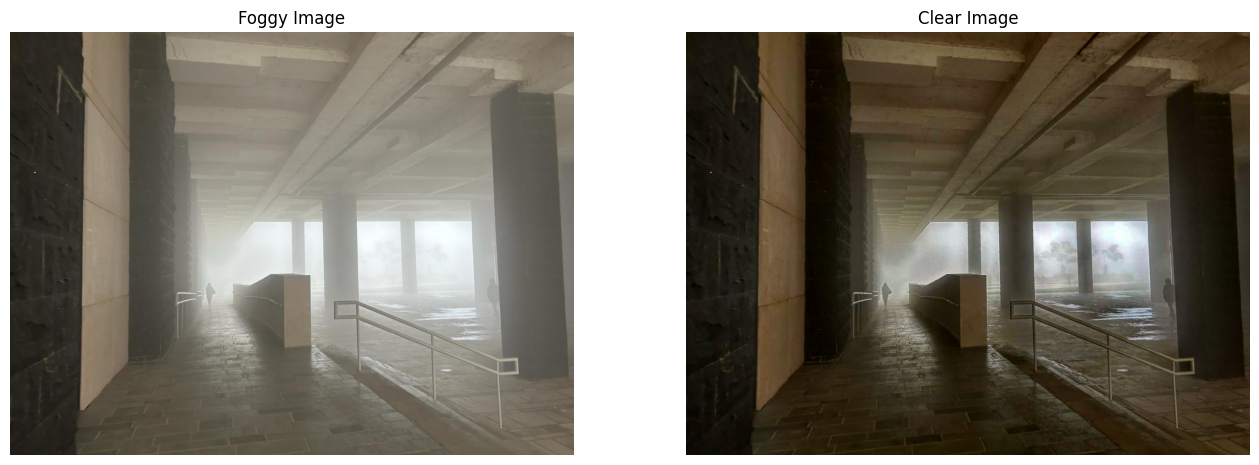

In [31]:
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(HazeImg,cv2.COLOR_BGR2RGB))
plt.title('Foggy Image')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(HazeCorrectedImg,cv2.COLOR_BGR2RGB))
plt.title('Clear Image')
plt.axis("off")